In [1]:
import sys

sys.path.append("../extraction_core/")
from predict import TableExtractor

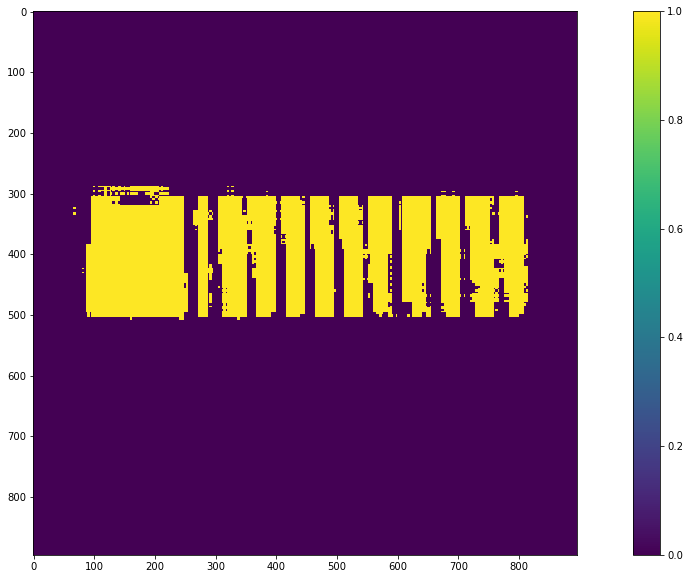

In [2]:
import albumentations as album
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt

transforms = album.Compose([
        album.Resize(896, 896, always_apply=True),
        album.Normalize(),
        ToTensorV2()
    ])
    
checkpoint_path = "projet-ssplab/comptes-sociaux/logs/TableNetModule/version_00/checkpoints/marmot_model.ckpt"
table_extractor = TableExtractor(checkpoint_path=checkpoint_path, transforms=transforms)

TEST_DATA = [
    "305756413"
]
data_dir = "../extraction_core/data/marmot_data"
test_images = [Path(data_dir).joinpath(path + ".bmp") for path in TEST_DATA]

for siren, image_path in zip(TEST_DATA, test_images):
    image = Image.open(image_path)
    out = table_extractor.extract(image)

    plt.rcParams["figure.figsize"] = (20,10)
    plt.plot()
    plt.imshow(out['column_mask'], interpolation='none')
    plt.colorbar(orientation='vertical')
    plt.savefig("column_mask.png")

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(image)

In [ ]:
fields = ['quote-part du capital détenue (en %)',
          'valeur brute comptable des titres détenus (en K euros)',
          'valeur nette comptable des titres détenus (en K euros)',
          "dividendes encaissés par la société en cours d'exercice (en K euros)",
          'résultats (bénéfices ou pertes à 100%) du dernier exercice clos (en K devises)']

In [ ]:
out['tables'][0]

Concaténation du texte de chaque colonne

In [ ]:
column_contents = []
for name, value in out['tables'][0].iteritems():
    value_cleaned = value.dropna()
    column_contents.append(' '.join(value_cleaned))

Use of built-in `SequenceMatcher` or `Levenshtein` library :

In [ ]:
from difflib import SequenceMatcher
from Levenshtein import ratio as levenshtein_diff

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

print(similar('hello world', 'hello'))
print(levenshtein_diff('hello world', 'hello'))

In [ ]:
import numpy as np

similarities = []
lev_similarities = []
for content in column_contents:
    similarities.append(np.array([similar(content, field) for field in fields]))
    lev_similarities.append(np.array([levenshtein_diff(content, field) for field in fields]))

In [ ]:
similarities = np.stack(similarities)
similarities

In [ ]:
similarities.shape

In [ ]:
lev_similarities = np.stack(lev_similarities)
lev_similarities

In [ ]:
lev_similarities.shape

Shape: number of colums in dataframe x 5 (number of columns to find). For each of the five columns, we want the column of the dataframe with the top similary, given that it is above a certain threshold. In this first case we suppose that one column of the dataframe can not correspond to more than 1 of the columns to find. This is a stable marriage problem. Without this constraint we simply have:

In [ ]:
similarities.argmax(0)

In [ ]:
similarities.max(0) > 0.5

In [ ]:
threshold = 0.5
mapping = np.array([argmax if above_thresh else np.nan for argmax, above_thresh in zip(similarities.argmax(0), similarities.max(0) > threshold)])
mapping

Now for the stable marriage problem:

In [ ]:
order = similarities.argsort(0)

In [ ]:
FREE = -1 # special value to indicate no match yet
match = FREE * np.ones(len(fields), dtype=np.int_) # vector of -1s of the length of the target columns vector
jnext = len(column_contents) * np.ones(len(fields), dtype=np.int_) # vector of values the length of number of columns obtained in df and length of the target columns vector

In [ ]:
match

In [ ]:
jnext

In [ ]:
# reverse match: if string in column_contents is matched to a string in fields
rev_match = FREE * np.ones(len(column_contents), dtype=np.int_)
rev_match

In [ ]:
while(np.any(match == FREE)): # while there is an un-matched string
    i = np.where(match == FREE)[0][0] # take the first un-matched index
    jnext[i] -= 1
    j = order[jnext[i], i] # next column_contents string that fields[i] will be matched against
    if rev_match[j] == FREE:  # column_contents[j] is free, pair i & j together
        rev_match[j], match[i] = i, j
        print('{:30} --> {}'.format(fields[i], column_contents[j]))
    else: # column_contents[j] is already paired
        l = rev_match[j] # current fields string that column_contents[j] is paired with
        if similarities[j, l] < similarities[j, i]:  # column_contents[j] is more similar to fields[i] than fields[l]
            match[l] = FREE      # unpair l & j, and pair i & j
            rev_match[j], match[i] = i, j
            print('{:30} -/- {}'.format(fields[l], column_contents[j]))
            print('{:30} --> {}'.format(fields[i], column_contents[j]))

In [ ]:
for i, w in enumerate(fields):
    print('{:30} {}'.format(w, column_contents[match[i]]))

In [ ]:
match

In [ ]:
similarities.shape

In [ ]:
similarities

In [ ]:
np.take_along_axis(similarities, np.expand_dims(match, 0), axis=0)

In [ ]:
threshold = 0.5
filter_array = (np.take_along_axis(similarities, np.expand_dims(match, 0), axis=0) > threshold).squeeze()

In [ ]:
mapping = np.array([argmax if above_thresh else np.nan for argmax, above_thresh in zip(match, filter_array)])
mapping

Jaro-Winckler similarity ?

In [ ]:
import jellyfish

jellyfish.jaro_winkler('Carol','elephant') 

Option 2 : detection of fuzzy/approximate key word or key n-gram in columns

In [ ]:
import regex
text = "Monalisa was painted by Leoxnrdo da Vinchi"
regex.search(r'\b(leonardo){e<3}\s+(da)\s+(vinci){e<2}\b', text, flags=regex.IGNORECASE)

In [ ]:
fields = ['quote-part du capital détenue (en %)',
          'valeur brute comptable des titres détenus (en K euros)',
          'valeur nette comptable des titres détenus (en K euros)',
          "dividendes encaissés par la société en cours d'exercice (en K euros)",
          'résultats (bénéfices ou pertes à 100%) du dernier exercice clos (en K devises)']
regexes = [r'\b(quote-part){e<2}\b',
           r'(valeur){e<1}.+(brute){e<1}',
           r'(valeur){e<1}.+(nette){e<1}',
           r'\b(dividende){e<2}\b',
           r'\b(resultat){e<3}\b',]

In [ ]:
column_contents

In [ ]:
fuzzy_matches = []

for content in column_contents:
    fuzzy_matches.append(np.array([1 if regex.search(regex_pattern, content, flags=regex.IGNORECASE) else 0 for regex_pattern in regexes]))

In [ ]:
fuzzy_matches = np.stack(fuzzy_matches)
fuzzy_matches

In [ ]:
out['tables'][0]

Combinaison des méthodes, on multiplie les matrices terme à terme + si pour un titre de colonne on n'a aucun fuzzy match, on n'apparie pas

In [ ]:
similarities * fuzzy_matches

In [ ]:
similarities.shape

In [ ]:
def stable_match(similarities):
    order = similarities.argsort(0)
    ncolumns_to_match = order.shape[1]
    ncolumns = order.shape[0]
    
    FREE = -1 # special value to indicate no match yet
    match = FREE * np.ones(ncolumns_to_match, dtype=np.int_) # vector of -1s of the length of the target columns vector
    jnext = ncolumns * np.ones(ncolumns_to_match, dtype=np.int_) # vector of values the length of number of columns obtained in df and length of the target columns vector
    
    rev_match = FREE * np.ones(ncolumns, dtype=np.int_)
    
    while(np.any(match == FREE)): 
        i = np.where(match == FREE)[0][0] 
        jnext[i] -= 1
        j = order[jnext[i], i] 
        if rev_match[j] == FREE:  
            rev_match[j], match[i] = i, j
        else: 
            l = rev_match[j] 
            if similarities[j, l] < similarities[j, i]:  
                match[l] = FREE      
                rev_match[j], match[i] = i, j
                
    return match

In [ ]:
stable_match(similarities * fuzzy_matches)

In [ ]:
np.take_along_axis(similarities * fuzzy_matches, np.expand_dims(stable_match(similarities * fuzzy_matches), 0), axis=0)

In [ ]:
np.where(np.take_along_axis(similarities * fuzzy_matches, np.expand_dims(stable_match(similarities * fuzzy_matches), 0), axis=0),
         stable_match(similarities * fuzzy_matches),
         np.nan)

Ne prendre que le header de la colonne ?

In [ ]:
out['tables'][0].head()

Enlever la première colonne ? 

In [ ]:
out['tables'][0].iloc[:, 1:].head()

In [ ]:
row_types = []

for row_index, row in out['tables'][0].iloc[:, 1:].iterrows():
    row_cleaned = row.dropna()
    row_as_string = ' '.join(row_cleaned)
    
    numbers = sum(c.isdigit() for c in row_as_string)
    letters = sum(c.isalpha() for c in row_as_string)
    spaces  = sum(c.isspace() for c in row_as_string)
    others  = len(row_as_string) - numbers - letters - spaces
    
    try:
        if numbers / len(row_as_string) > 0.2:
            row_types.append(True)
        else:
            row_types.append(False)
    except ZeroDivisionError:
        row_types.append(False)
        
row_types

In [ ]:
np.where(row_types)[0][0]

In [ ]:
np.arange(np.where(row_types)[0][0])

In [ ]:
out['tables'][0]

In [ ]:
header_df = out['tables'][0].iloc[np.arange(np.where(row_types)[0][0])]

In [ ]:
fields = ['quote-part du capital détenue (en %)',
          'valeur brute comptable des titres détenus (en K euros)',
          'valeur nette comptable des titres détenus (en K euros)',
          "dividendes encaissés par la société en cours d'exercice (en K euros)",
          'résultats (bénéfices ou pertes à 100%) du dernier exercice clos (en K devises)']

Concaténation du texte de chaque colonne

In [ ]:
column_contents = []
for name, value in header_df.iteritems():
    value_cleaned = value.dropna()
    column_contents.append(' '.join(value_cleaned))

Use of built-in `SequenceMatcher` or `Levenshtein` library :

In [ ]:
similarities = []
for content in column_contents:
    similarities.append(np.array([similar(content, field) for field in fields]))

In [ ]:
similarities = np.stack(similarities)
similarities

In [ ]:
regexes = [r'\b(quote-part){e<2}\b',
           r'(valeur){e<1}.+(brute){e<1}',
           r'(valeur){e<1}.+(nette){e<1}',
           r'\b(dividende){e<3}\b',
           r'\b(resultat){e<3}\b',]

In [ ]:
fuzzy_matches = []

for content in column_contents:
    fuzzy_matches.append(np.array([1 if regex.search(regex_pattern, content, flags=regex.IGNORECASE) else 0 for regex_pattern in regexes]))

In [ ]:
fuzzy_matches = np.stack(fuzzy_matches)
fuzzy_matches

In [ ]:
stable_match(similarities * fuzzy_matches)

In [ ]:
def get_row_types(df):
    row_types = []

    for row_index, row in df.iterrows():
        row_cleaned = row.dropna()
        row_as_string = ''.join(row_cleaned)

        numbers = sum(c.isdigit() for c in row_as_string)
        letters = sum(c.isalpha() for c in row_as_string)
        spaces  = sum(c.isspace() for c in row_as_string)
        others  = len(row_as_string) - numbers - letters - spaces

        try:
            if numbers / len(row_as_string) > 0.2:
                row_types.append(True)
            else:
                row_types.append(False)
        except ZeroDivisionError:
            row_types.append(False)

    return row_types

In [ ]:
def create_clean_df(df, fields, regexes):
    df_without_first_column = df.iloc[:, 1:]
    row_types = get_row_types(df_without_first_column)
    
    header_rows = np.arange(np.where(row_types)[0][0])
    body_rows = np.arange(np.where(row_types)[0][0], df.shape[0])
    
    header_df = df.iloc[header_rows]
    body_df = df.iloc[body_rows]

    column_contents = []
    similarities = []
    fuzzy_matches = []

    for name, value in header_df.iteritems():
        value_cleaned = value.dropna()
        content = ' '.join(value_cleaned)
        similarities.append(np.array([similar(content, field) for field in fields]))
        fuzzy_matches.append(np.array([1 if regex.search(regex_pattern, content, flags=regex.IGNORECASE) else 0 for regex_pattern in regexes]))
    
    similarities = np.stack(similarities)
    fuzzy_matches = np.stack(fuzzy_matches)

    column_match = stable_match(similarities * fuzzy_matches)
    scores = np.take_along_axis(similarities * fuzzy_matches, np.expand_dims(column_match, 0), axis=0)
    
    column_match_with_nan = np.where(scores, column_match, -1).squeeze()
    filtered_fields = [i for (i, v) in zip(fields, list(column_match_with_nan >= 0)) if v]
    df_to_return = body_df.iloc[:, column_match_with_nan[column_match_with_nan >= 0]]
    df_to_return.columns = filtered_fields
    df_to_return.index = body_df.iloc[:, 0]
    return df_to_return

In [ ]:
create_clean_df(out['tables'][0], fields, regexes)

In [ ]:
out['tables'][0]

In [ ]:
from table_cleaner import TableCleaner

In [ ]:
cleaner = TableCleaner(fields, regexes)

In [ ]:
cleaner.clean_df(out['tables'][0])

In [ ]:
type(out['tables'][0])

Comment nettoyer les lignes ?

1) Si que des Nan, on peut retirer la ligne..

In [ ]:
test = cleaner.clean_df(out['tables'][0])

In [ ]:
test = test.dropna(axis=0, how='all')

In [ ]:
test

## Deuxième structure de tableau possible

In [ ]:
TEST_DATA = [
    "344066733"
]
data_dir = "../extraction_core/data/marmot_data"
test_images = [Path(data_dir).joinpath(path + ".bmp") for path in TEST_DATA]

for siren, image_path in zip(TEST_DATA, test_images):
    image = Image.open(image_path)
    out = table_extractor.extract(image)

    plt.rcParams["figure.figsize"] = (20,10)
    plt.plot()
    plt.imshow(out['column_mask'], interpolation='none')
    plt.colorbar(orientation='vertical')
    plt.savefig("column_mask.png")

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(image)

In [ ]:
out['tables'][0]

In [ ]:
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, convex_hull_image, binary_dilation
from skimage.transform import resize
from skimage.util import invert
import numpy as np

thresh = threshold_otsu(np.expand_dims(np.array(image.convert('L')), axis=-1))
bw = np.expand_dims(np.array(image.convert('L')), axis=-1) > thresh

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(bw, cmap='gray')

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(np.invert(bw), cmap='gray')

In [ ]:
bw.shape

In [ ]:
import cv2

In [ ]:
# grab contours
cs, _ = cv2.findContours(np.invert(bw).astype('uint8'), mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE )

In [ ]:
len(cs)

In [ ]:
# set up the 'FilledImage' bit of regionprops.
filledI = np.zeros(np.invert(bw).shape[0:2]).astype('uint8')
# set up the 'ConvexImage' bit of regionprops.
convexI = np.zeros(np.invert(bw).shape[0:2]).astype('uint8')

In [ ]:
largest_inverted_area = 0
index = 0

for i, c in enumerate(cs):
    m = cv2.moments(c)

    # ** regionprops ** 
    area = m['m00']
    perimeter = cv2.arcLength(c, True)
    # bounding box: x, y, width, height
    bb = cv2.boundingRect(c)
    # centroid = m10/m00, m01/m00 (x, y)
    centroid = (m['m10']/m['m00'], m['m01']/m['m00'])

    # EquivDiameter: diameter of circle with same area as region
    equiv_diameter = np.sqrt(4*area/np.pi)
    # Extent: ratio of area of region to area of bounding box
    extent = area/(bb[2]*bb[3])

    # FilledImage: draw the region on in white
    if area > largest_inverted_area:
        largest_inverted_area = area
        index = i
    # calculate indices of that region..
    region_mask = filledI == 255
    # FilledArea: number of pixels filled in FilledImage
    filled_area = np.sum(region_mask)
    # PixelIdxList : indices of region. 
    # (np.array of xvals, np.array of yvals)
    pixel_idx_list  = region_mask.nonzero()
    
selected_contour = cv2.drawContours(filledI, cs, index, color=255, thickness=-1)

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(selected_contour)

In [ ]:
region_mask = selected_contour == 255

In [ ]:
modified_image = bw * (1 - np.expand_dims(region_mask, -1)) + np.invert(bw) * np.expand_dims(region_mask, -1)

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(modified_image, cmap='gray')

In [ ]:
modified_image = image * (1 - np.expand_dims(region_mask, -1)) + np.invert(image) * np.expand_dims(region_mask, -1)

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(modified_image)

In [ ]:
type(Image.fromarray(np.uint8(modified_image)).convert('RGB'))

In [ ]:
pil_modified_image = Image.fromarray(np.uint8(modified_image)).convert('RGB')

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(pil_modified_image)

In [ ]:
out = table_extractor.extract(image)

In [ ]:
out['tables'][0]

Il faut essayer de faire tourner le modèle sur l'image originale et d'utiliser Tesseract sur l'image modifiée.

In [ ]:
out = table_extractor.extract(image, True)

In [ ]:
out['tables'][0]

In [ ]:
out = table_extractor.extract(image, True, True)

In [ ]:
out['tables'][0]

In [ ]:
out = table_extractor.extract(image, False, True)

In [ ]:
out['tables'][0]

#### Test if image has some dark spots that one should invert colors for

In [7]:
TEST_DATA = [
    "344066733"
    #"305756413"
]
data_dir = "../extraction_core/data/marmot_data"
test_images = [Path(data_dir).joinpath(path + ".bmp") for path in TEST_DATA]

for siren, image_path in zip(TEST_DATA, test_images):
    image = Image.open(image_path)

In [8]:
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, convex_hull_image, binary_dilation
from skimage.transform import resize
from skimage.util import invert
import numpy as np

thresh = threshold_otsu(np.expand_dims(np.array(image.convert('L')), axis=-1))
bw = np.expand_dims(np.array(image.convert('L')), axis=-1) > thresh

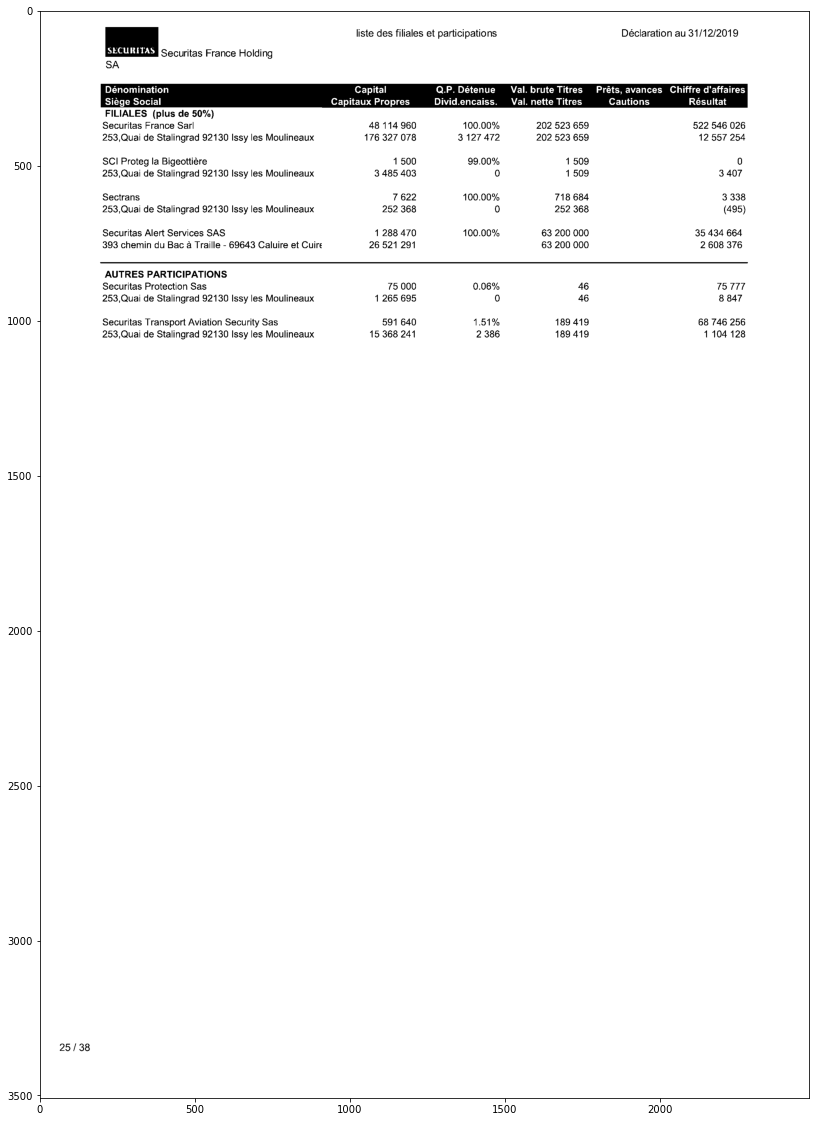

In [9]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(bw, cmap='gray')

In [ ]:
import cv2
# grab contours
cs, _ = cv2.findContours(np.invert(bw).astype('uint8'), mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE )

In [ ]:
len(cs)

In [ ]:
bw.shape

In [ ]:
image_area = bw.shape[0] * bw.shape[1]

In [ ]:
areas = []
for i, c in enumerate(cs):
    m = cv2.moments(c)

    # ** regionprops ** 
    areas.append(m['m00'] / image_area)

In [ ]:
plt.hist(areas, bins=20, alpha=0.5)
plt.show()

In [ ]:
np.sort(np.array(areas))[-5:]

In [ ]:
# set up the 'FilledImage' bit of regionprops.
filledI = np.zeros(np.invert(bw).shape[0:2]).astype('uint8')
# set up the 'ConvexImage' bit of regionprops.
convexI = np.zeros(np.invert(bw).shape[0:2]).astype('uint8')

In [ ]:
threshold_area = 1e-3

for i, c in enumerate(cs):
    m = cv2.moments(c)

    area = m['m00']
    if area / image_area > threshold_area:
        selected_contour = cv2.drawContours(filledI, cs, i, color=255, thickness=-1)

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(selected_contour)

In [ ]:
region_mask = selected_contour == 255

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(region_mask)

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(label(region_mask))

In [ ]:
for i in np.unique(label(region_mask))[1:]:
    table = np.where(label(region_mask) == i, 1, 0)
    plt.rcParams["figure.figsize"] = (40,20)
    plt.plot()
    plt.imshow(table)

In [ ]:
crop = bw[np.ix_(table.any(1), table.any(0))]

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(bw[np.ix_(table.any(1), table.any(0))], cmap="gray")

In [ ]:
len(crop[crop == 0])

In [ ]:
crop.shape

In [ ]:
810*2006

In [ ]:
len(crop[crop == 1])

In [ ]:
len(crop[crop == 1]) / (len(crop[crop == 0]) + len(crop[crop == 1]))

In [ ]:
crop[:20, :20] = 0

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(crop, cmap="gray")

In [ ]:
modified_image = bw * (1 - np.expand_dims(region_mask, -1)) + np.invert(bw) * np.expand_dims(region_mask, -1)

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(modified_image, cmap='gray')

In [ ]:
modified_image = image * (1 - np.expand_dims(region_mask, -1)) + np.invert(image) * np.expand_dims(region_mask, -1)

In [ ]:
plt.rcParams["figure.figsize"] = (40,20)
plt.plot()
plt.imshow(modified_image)

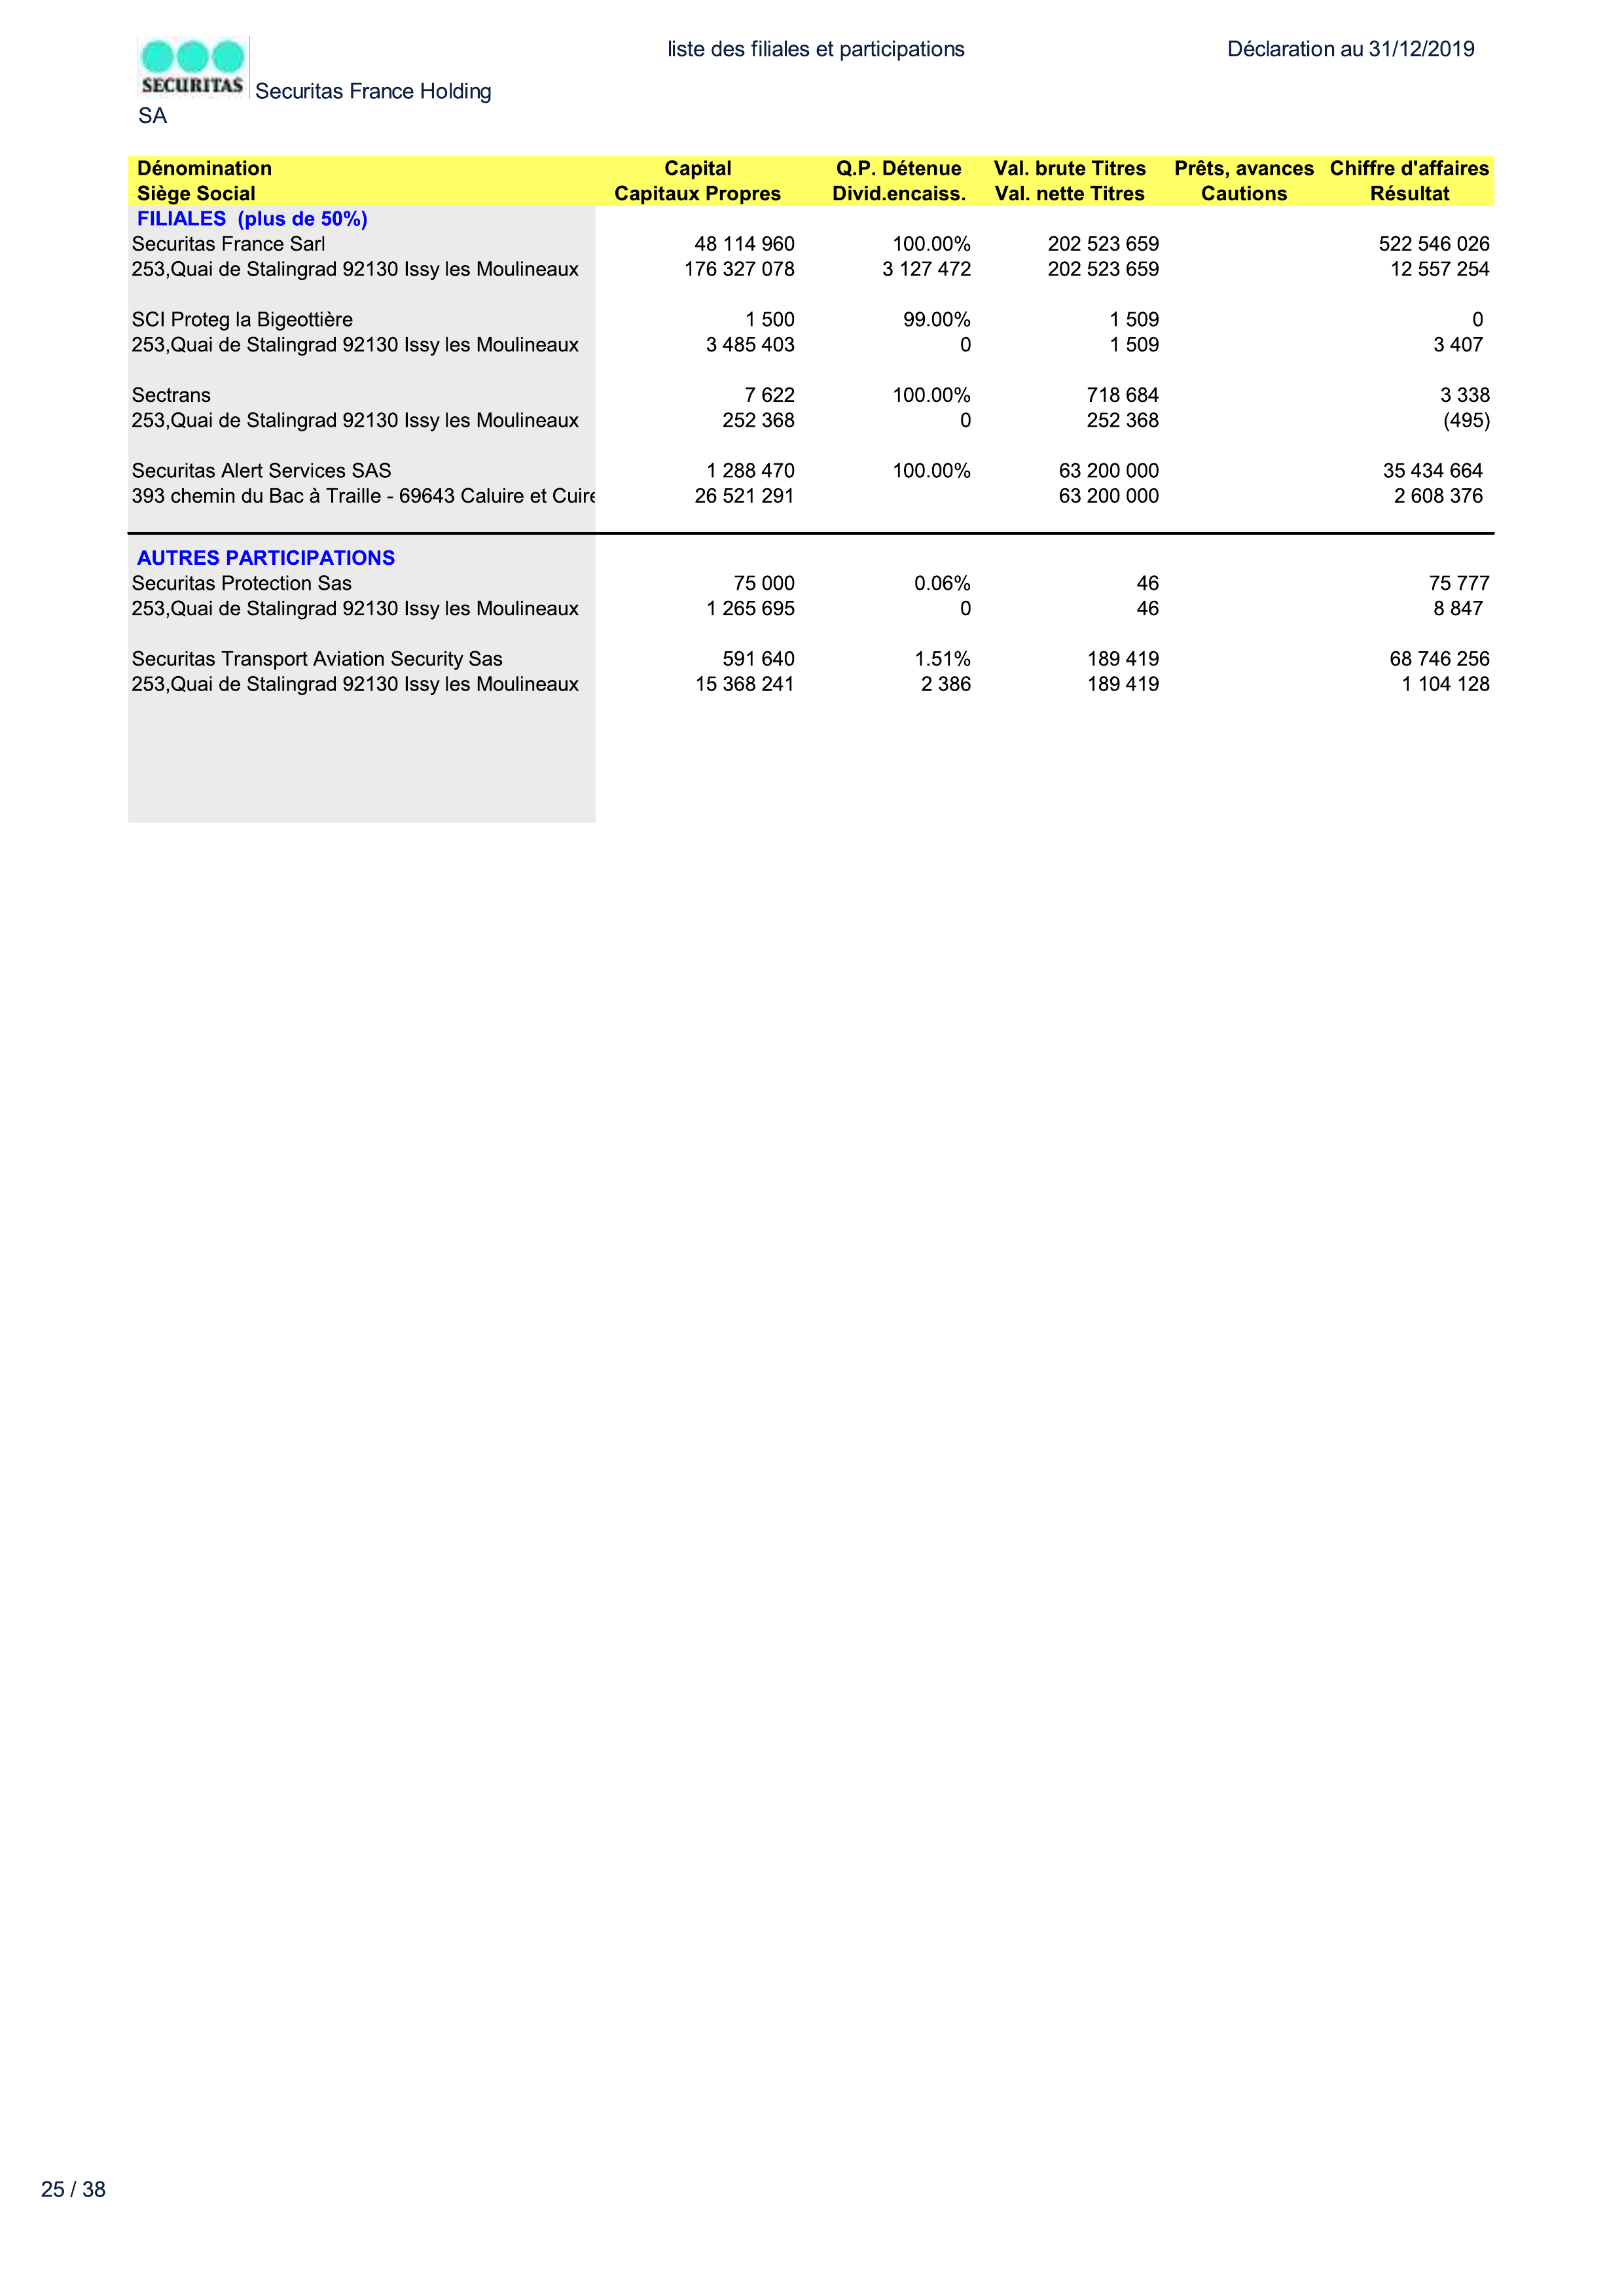

In [10]:
table_extractor.invert_dark_areas(image)